Script that trains MAVE-NN GE pairwise model on GB1 data from Olson et al. (2019)

In [2]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

import sys
#path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn'
path_to_mavenn = '/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/'
sys.path.insert(0,path_to_mavenn)

import mavenn

In [3]:
mavenn.__path__

['/Users/tareen/Desktop/Research_Projects/2020_mavenn_github/mavenn_git_ssh/mavenn']

In [4]:
# Load example data (WHICH CONTAINS DOUBLE MUTANTS ONLY!)
data_df = mavenn.load_example_dataset('gb1')

# Separate test from data_df
ix_test = data_df['set']=='test'
test_df = data_df[ix_test].reset_index(drop=True)
print(f'test N: {len(test_df):,}')

# Remove test data from data_df
data_df = data_df[~ix_test].reset_index(drop=True)
print(f'training + validation N: {len(data_df):,}')
data_df.head(10)

test N: 26,364
training + validation N: 504,373


,set,dist,input_ct,selected_ct,y,x
0,training,2,173,33,-3.145154,AAKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
1,training,2,18,8,-1.867676,ACKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
2,training,2,66,2,-5.270800,ADKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
3,training,2,72,1,-5.979498,AEKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
4,training,2,69,168,0.481923,AFKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
5,training,2,108,1,-6.557858,AGKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
6,training,2,48,93,0.150206,AHKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
7,training,2,119,49,-2.052708,AIKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
8,training,2,252,79,-2.450739,ALKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...
9,training,2,110,116,-0.713724,AMKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDD...


In [5]:
len(data_df)

504373

In [9]:
L = len(data_df['x'][0])

In [6]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

In [10]:
# Define model
model = mavenn.Model(L=L,
                     alphabet='protein',
                     gpmap_type='additive', 
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)


In [11]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               shuffle=True)

N = 504,373 observations set as training data.
Using 19.9% for validation.
Data shuffled.
Time to set data: 24.5 sec.


In [13]:
# Fit model to data
model.fit(learning_rate=.005,
          epochs=1000,
          batch_size=500,
          early_stopping=True,
          try_tqdm=False,
          early_stopping_patience=30,
          linear_initialization=True)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has   404218 rows  and     1100 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1100

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  6.357e+02  6.434e+04   1.0e+00  1.6e-01
     1  3.00204e-05  6.353e+02  6.422e+04   1.0e+00  4.2e-01  2.4e+02  1.0e+00
     2  3.01769e-02  3.590e+02  7.628e+03   5.6e-01  4.7e-03  4.5e+03  2.8e+01
     3  4.24636e-02  2.983e+02  6.079e+03   4.7e-01  4.5e-03  4.5e+03  1.3e+02
     4  6.79716e-02  2.332e+02  3.100e+02   3.7e-01  2.9e-04  4.5e+03  8.0e+01
     5  6.79633e-02  2.332e+02  3.077e+02   3.7e-01  2.9e-04  4.5e+03  8.0e+01
     6  6.76232e-02  2.332e+02  2.002e+02   3.7e-01  1.3e-04  6.4e+03  8.0e+01
     7  6.26669e-02  2.331e+02  1.244e+02   3.7e-01  8.3e-05  6.4e+03  1.4e+02
     8  5.94136e-02  2.331e+02  2.016e+01   3.7e-01  1.3e-05  6.4e+03  1.1

Epoch 47/1000
809/809 [==============================] - 3s 4ms/step - loss: -137.0466 - I_var: 2.1539 - val_loss: -106.1776 - val_I_var: 2.0692
Epoch 48/1000
809/809 [==============================] - 3s 4ms/step - loss: -136.5748 - I_var: 2.1553 - val_loss: -139.0489 - val_I_var: 2.1645
Epoch 49/1000
809/809 [==============================] - 3s 4ms/step - loss: -138.6120 - I_var: 2.1564 - val_loss: -138.8544 - val_I_var: 2.1642
Epoch 50/1000
809/809 [==============================] - 3s 4ms/step - loss: -137.1377 - I_var: 2.1534 - val_loss: -138.1223 - val_I_var: 2.1622
Epoch 51/1000
809/809 [==============================] - 3s 4ms/step - loss: -134.6825 - I_var: 2.1540 - val_loss: -138.7515 - val_I_var: 2.1641
Epoch 52/1000
809/809 [==============================] - 3s 4ms/step - loss: -136.9688 - I_var: 2.1569 - val_loss: -137.7634 - val_I_var: 2.1615
Epoch 53/1000
809/809 [==============================] - 3s 4ms/step - loss: -136.7456 - I_var: 2.1563 - val_loss: -115.9575 - val

In [14]:
# Save model
model.save('gb1_ge_additive')

Model saved to these files:
	gb1_ge_additive.pickle
	gb1_ge_additive.h5


On test data:
I_var_test: 2.176 +- 0.012 bits
I_pred_test: 2.218 +- 0.007 bits


Text(0.5, 1.0, 'training history - subsampled model')

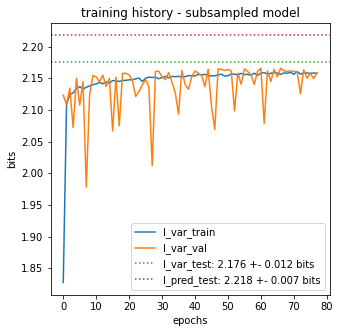

In [16]:
# Show training history
print('On test data:')

# Compute likelihood information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[5,5])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label=f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits')
ax.axhline(I_pred, color='C3', linestyle=':', label=f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training history - subsampled model')

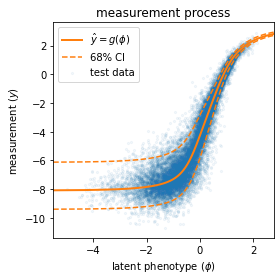

In [17]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.05, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

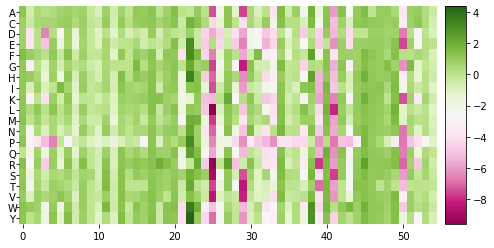

In [18]:
# Plot pairwise parameters
theta = model.get_theta()
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap(values=theta['theta_lc'],
                        alphabet=theta['alphabet'],
                        ax=ax,
                        cmap='PiYG');

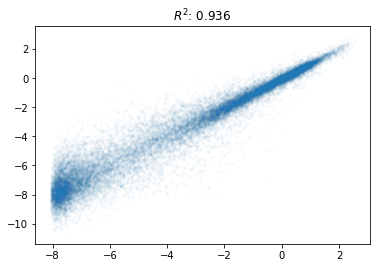

In [19]:
yhat_test = model.x_to_yhat(x_test)
Rsq = np.corrcoef(y_test,yhat_test)[0][1]**2

plt.title('$R^2$: '+str(Rsq)[0:5])
plt.scatter(yhat_test,y_test,s=5,alpha=0.02)

In [20]:
gb1_sim_model = model.bootstrap(data_df=data_df,num_models=5)

Training set   :  477,854 observations (  94.74%)
Validation set :   26,519 observations (   5.26%)
Test set       :        0 observations (   0.00%)
-------------------------------------------------
Total dataset  :  504,373 observations ( 100.00%)

training model 0 ...
N = 504,373 observations set as training data.
Using 5.3% for validation.
Data shuffled.
Time to set data: 16.8 sec.
 
LSMR            Least-squares solution of  Ax = b

The matrix A has   477854 rows  and     1100 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =     1100

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  6.913e+02  7.522e+04   1.0e+00  1.6e-01
     1  4.42611e-04  6.843e+02  7.462e+04   9.9e-01  8.0e-01  1.4e+02  1.0e+00
     2  2.89369e-02  3.980e+02  9.227e+03   5.8e-01  4.7e-03  4.9e+03  1.8e+00
     3  2.99705e-02  3.900e+02  9.051e+03   5.6e-01  4.7e-03  4.9e+03  3.4e+01
 

956/956 [==============================] - 3s 3ms/step - loss: -129.2189 - I_var: 2.1858 - val_loss: -128.4483 - val_I_var: 2.1806
Epoch 45/1000
956/956 [==============================] - 3s 3ms/step - loss: -125.6784 - I_var: 2.1852 - val_loss: -122.7902 - val_I_var: 2.1617
Epoch 46/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.0247 - I_var: 2.1852 - val_loss: -127.8959 - val_I_var: 2.1800
Epoch 47/1000
956/956 [==============================] - 3s 3ms/step - loss: -125.8530 - I_var: 2.1854 - val_loss: -129.0085 - val_I_var: 2.1832
Epoch 48/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.3849 - I_var: 2.1870 - val_loss: -125.9986 - val_I_var: 2.1774
Epoch 49/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.3697 - I_var: 2.1872 - val_loss: -126.8279 - val_I_var: 2.1750
Epoch 50/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.4807 - I_var: 2.1866 - val_loss: -129.0719 - val_I_var: 2.1831

956/956 [==============================] - 3s 3ms/step - loss: -128.6263 - I_var: 2.1869 - val_loss: -128.3494 - val_I_var: 2.1839
Epoch 101/1000
956/956 [==============================] - 3s 3ms/step - loss: -129.0492 - I_var: 2.1897 - val_loss: -127.6380 - val_I_var: 2.1805
Epoch 102/1000
956/956 [==============================] - 3s 3ms/step - loss: -125.9919 - I_var: 2.1855 - val_loss: -118.7213 - val_I_var: 2.1531
Epoch 103/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.1824 - I_var: 2.1883 - val_loss: -127.3694 - val_I_var: 2.1818
Training time: 346.1 seconds
Training set   :  477,854 observations (  94.74%)
Validation set :   26,519 observations (   5.26%)
Test set       :        0 observations (   0.00%)
-------------------------------------------------
Total dataset  :  504,373 observations ( 100.00%)

training model 1 ...
N = 504,373 observations set as training data.
Using 5.3% for validation.
Data shuffled.
Time to set data: 16.7 sec.
 
LSMR       

956/956 [==============================] - 3s 3ms/step - loss: -126.9089 - I_var: 2.1644 - val_loss: -137.9324 - val_I_var: 2.1994
Epoch 40/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.6833 - I_var: 2.1640 - val_loss: -120.4787 - val_I_var: 2.1487
Epoch 41/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.0066 - I_var: 2.1651 - val_loss: -135.4666 - val_I_var: 2.1921
Epoch 42/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.1275 - I_var: 2.1641 - val_loss: -109.3159 - val_I_var: 2.1180
Epoch 43/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.0753 - I_var: 2.1641 - val_loss: -128.5641 - val_I_var: 2.1743
Epoch 44/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.7158 - I_var: 2.1650 - val_loss: -135.5595 - val_I_var: 2.1934
Epoch 45/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.3775 - I_var: 2.1669 - val_loss: -126.1196 - val_I_var: 2.1654

Epoch 24/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.5787 - I_var: 2.1565 - val_loss: -125.8181 - val_I_var: 2.1548
Epoch 25/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.6217 - I_var: 2.1546 - val_loss: -129.0869 - val_I_var: 2.1639
Epoch 26/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.3384 - I_var: 2.1564 - val_loss: -130.0924 - val_I_var: 2.1667
Epoch 27/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.6819 - I_var: 2.1562 - val_loss: -129.0102 - val_I_var: 2.1632
Epoch 28/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.2909 - I_var: 2.1542 - val_loss: -127.8016 - val_I_var: 2.1625
Epoch 29/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.9465 - I_var: 2.1588 - val_loss: -123.9536 - val_I_var: 2.1506
Epoch 30/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.6234 - I_var: 2.1591 - val_loss: -127.5898 - val

Epoch 11/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.1510 - I_var: 2.1485 - val_loss: -132.0569 - val_I_var: 2.1674
Epoch 12/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.2425 - I_var: 2.1475 - val_loss: -131.4371 - val_I_var: 2.1625
Epoch 13/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.4448 - I_var: 2.1472 - val_loss: -125.0072 - val_I_var: 2.1460
Epoch 14/1000
956/956 [==============================] - 3s 3ms/step - loss: -130.0991 - I_var: 2.1516 - val_loss: -114.1433 - val_I_var: 2.1160
Epoch 15/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.4909 - I_var: 2.1496 - val_loss: -123.5245 - val_I_var: 2.1447
Epoch 16/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.5387 - I_var: 2.1491 - val_loss: -129.7360 - val_I_var: 2.1578
Epoch 17/1000
956/956 [==============================] - 3s 3ms/step - loss: -129.9739 - I_var: 2.1519 - val_loss: -131.2149 - val

956/956 [==============================] - 3s 3ms/step - loss: -131.2204 - I_var: 2.1632 - val_loss: -132.6920 - val_I_var: 2.1759
Epoch 68/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.5172 - I_var: 2.1621 - val_loss: -132.1291 - val_I_var: 2.1732
Epoch 69/1000
956/956 [==============================] - 3s 3ms/step - loss: -132.3827 - I_var: 2.1628 - val_loss: -133.5462 - val_I_var: 2.1773
Epoch 70/1000
956/956 [==============================] - 3s 3ms/step - loss: -130.5286 - I_var: 2.1616 - val_loss: -131.6022 - val_I_var: 2.1722
Epoch 71/1000
956/956 [==============================] - 3s 3ms/step - loss: -129.9562 - I_var: 2.1617 - val_loss: -130.8685 - val_I_var: 2.1707
Epoch 72/1000
956/956 [==============================] - 3s 3ms/step - loss: -129.8781 - I_var: 2.1634 - val_loss: -133.9121 - val_I_var: 2.1792
Epoch 73/1000
956/956 [==============================] - 3s 3ms/step - loss: -130.6047 - I_var: 2.1628 - val_loss: -130.3393 - val_I_var: 2.1692

     2  2.94155e-02  3.980e+02  9.230e+03   5.8e-01  4.7e-03  4.9e+03  5.5e+00
     3  2.99386e-02  3.951e+02  9.166e+03   5.7e-01  4.7e-03  4.9e+03  6.0e+01
     4  4.52704e-02  3.186e+02  7.011e+03   4.6e-01  3.2e-03  7.0e+03  7.1e+00
     5  7.17479e-02  2.568e+02  2.736e+02   3.7e-01  1.5e-04  7.0e+03  2.3e+01
     6  7.17482e-02  2.568e+02  2.731e+02   3.7e-01  1.5e-04  7.0e+03  2.3e+01
     7  7.18938e-02  2.568e+02  1.913e+02   3.7e-01  8.7e-05  8.6e+03  5.7e+01
     8  7.19037e-02  2.568e+02  1.908e+02   3.7e-01  8.7e-05  8.6e+03  1.6e+02
     9  7.32266e-02  2.567e+02  9.771e+01   3.7e-01  3.9e-05  9.9e+03  5.7e+01
    10  7.36488e-02  2.567e+02  4.124e+01   3.7e-01  1.6e-05  9.9e+03  5.7e+01
    16  7.35764e-02  2.567e+02  3.402e+00   3.7e-01  1.0e-06  1.3e+04  6.8e+01
 
LSMR finished
The least-squares solution is good enough, given atol     
istop =       2    normr = 2.6e+02
    normA = 1.3e+04    normAr = 3.4e+00
itn   =      16    condA = 6.8e+01
    normx = 1.1e+01
    1

Epoch 50/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.3353 - I_var: 2.1609 - val_loss: -129.9673 - val_I_var: 2.1646
Epoch 51/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.0036 - I_var: 2.1587 - val_loss: -131.7417 - val_I_var: 2.1712
Epoch 52/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.9746 - I_var: 2.1601 - val_loss: -127.5489 - val_I_var: 2.1574
Epoch 53/1000
956/956 [==============================] - 3s 3ms/step - loss: -126.9144 - I_var: 2.1617 - val_loss: -129.4007 - val_I_var: 2.1625
Epoch 54/1000
956/956 [==============================] - 3s 3ms/step - loss: -127.6283 - I_var: 2.1611 - val_loss: -129.5761 - val_I_var: 2.1638
Epoch 55/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.3151 - I_var: 2.1595 - val_loss: -129.1321 - val_I_var: 2.1628
Epoch 56/1000
956/956 [==============================] - 3s 3ms/step - loss: -128.5548 - I_var: 2.1608 - val_loss: -127.8293 - val

In [23]:
for bs_idx, bootstrap_model in enumerate(gb1_sim_model):
    bootstrap_model.save(f'gb1_ge_sim_{bs_idx}')

Model saved to these files:
	gb1_ge_sim_0.pickle
	gb1_ge_sim_0.h5
Model saved to these files:
	gb1_ge_sim_1.pickle
	gb1_ge_sim_1.h5
Model saved to these files:
	gb1_ge_sim_2.pickle
	gb1_ge_sim_2.h5
Model saved to these files:
	gb1_ge_sim_3.pickle
	gb1_ge_sim_3.h5
Model saved to these files:
	gb1_ge_sim_4.pickle
	gb1_ge_sim_4.h5
